In [69]:
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
df = pd.read_pickle('my_df.pkl')

In [71]:
df.head(10)

,Race,Number of Deaths,Population,Crude Death Rate,Age Adjusted Death Rate,Confidence Interval,Standard Error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000
5,Asian or Pacific Islander,"9,415","11,757,685",80.1,124.7,1.4,0.1%,2000
6,Black or African American,"63,081","36,594,309",172.4,253.1,1.0,0.7%,2000
7,White,"492,182","230,085,762",213.9,202.2,0.3,5.7%,2000
8,American Indian or Alaska Native,"2,213","3,097,333",71.4,140.0,3.2,0.0%,2001
9,Asian or Pacific Islander,"9,992","12,429,181",80.4,122.7,1.3,0.1%,2001


In [72]:
df.isna().sum()

Race                       0
Number of Deaths           0
Population                 0
Crude Death Rate           0
Age Adjusted Death Rate    0
Confidence Interval        0
Standard Error             0
year                       0
dtype: int64

In [73]:
# remove capitals and replace spaces with underscores in column names
old_names = list(df.columns)
formatted_names = []
for name in old_names:
    name = str.lower(name)
    name = name.replace(' ', '_')
    formatted_names.append(name)

mapper = dict(zip(old_names, formatted_names))
df.rename(mapper = mapper, axis = 1, inplace = True)
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,"1,878","2,832,761",66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,"8,976","11,346,496",79.1,125.4,1.4,0.1%,1999
2,Black or African American,"63,124","36,173,121",174.5,257.3,1.0,0.7%,1999
3,White,"489,087","228,687,790",213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,"1,959","2,984,150",65.6,130.8,3.2,0.0%,2000


In [74]:
df.dtypes

race                       object
number_of_deaths           object
population                 object
crude_death_rate           object
age_adjusted_death_rate    object
confidence_interval        object
standard_error             object
year                       object
dtype: object

In [75]:
# format data to numeric type where appropriate
df = df.apply(lambda x: x.str.replace(',',''))
columns = list(df.columns)
for column in columns:
    df[column] = pd.to_numeric(df[column], errors = 'ignore')
df.head()

,race,number_of_deaths,population,crude_death_rate,age_adjusted_death_rate,confidence_interval,standard_error,year
0,American Indian or Alaska Native,1878,2832761,66.3,138.3,3.4,0.0%,1999
1,Asian or Pacific Islander,8976,11346496,79.1,125.4,1.4,0.1%,1999
2,Black or African American,63124,36173121,174.5,257.3,1.0,0.7%,1999
3,White,489087,228687790,213.9,202.9,0.3,5.6%,1999
4,American Indian or Alaska Native,1959,2984150,65.6,130.8,3.2,0.0%,2000


In [76]:
df.dtypes

race                        object
number_of_deaths             int64
population                   int64
crude_death_rate           float64
age_adjusted_death_rate    float64
confidence_interval        float64
standard_error              object
year                         int64
dtype: object

In [101]:
# add column for death rate as ordinary percentage
df['death_rate'] = df['crude_death_rate'] / 1000

In [102]:
# see mean death rate grouped by race over whole time period
racial_death_rate = df[['race', 'death_rate']].groupby('race').mean()
racial_death_rate.sort_values(by = 'death_rate', ascending = False)

,death_rate
race,
White,0.207947
Black or African American,0.163773
Asian or Pacific Islander,0.081980
American Indian or Alaska Native,0.068773


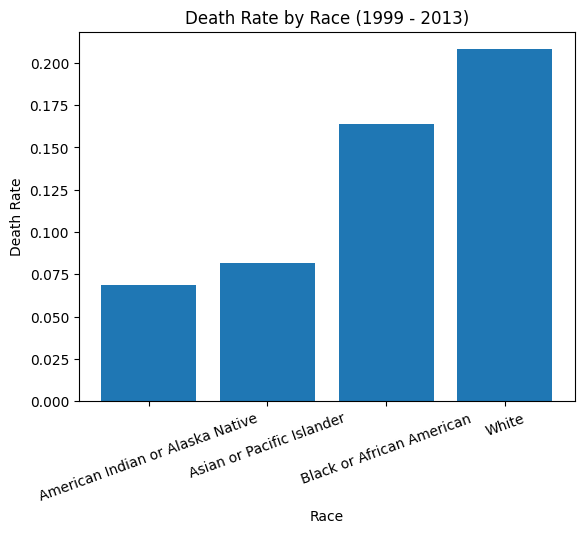

In [103]:
plt.bar(x = racial_death_rate.index, height = racial_death_rate['death_rate'])
plt.xticks(rotation = 20)
plt.title('Death Rate by Race (1999 - 2013)')
plt.ylabel('Death Rate')
plt.xlabel('Race')
plt.show()

In [104]:
# see death rate over time of all races aggregated
death_rate_over_time = df[['year', 'death_rate']].groupby('year').mean()
death_rate_over_time

,death_rate
year,
1999,0.133450
2000,0.133000
2001,0.133425
2002,0.132050
2003,0.130750
2004,0.130550
2005,0.130900
2006,0.129050
2007,0.129100


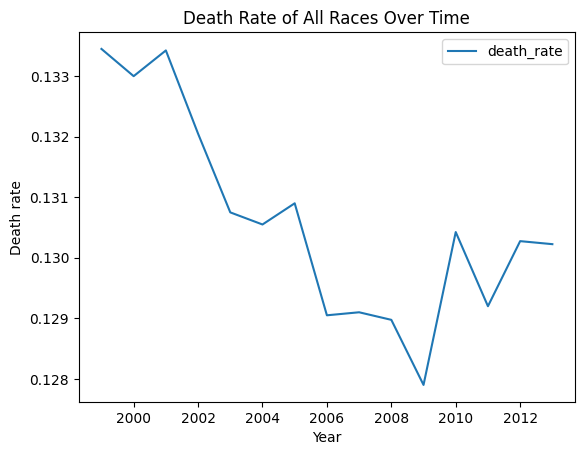

In [105]:
death_rate_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of All Races Over Time')
plt.show()

In [82]:
df['race'].unique()

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'White'], dtype=object)

In [107]:
# look at the death rate over time for each race separately
racial_dr_over_time = pd.DataFrame(index = range(len(df['year'].unique())))

racial_dr_over_time['American Indian or Alaska Native'] = df[df['race'] == 'American Indian or Alaska Native']['crude_death_rate'].reset_index(drop = True)

for race in df['race'].unique():
    racial_dr_over_time[race] = df[df['race'] == race]['crude_death_rate'].reset_index(drop = True)
racial_dr_over_time.set_index(df['year'].unique(), inplace = True)
racial_dr_over_time

,American Indian or Alaska Native,Asian or Pacific Islander,Black or African American,White
1999,66.3,79.1,174.5,213.9
2000,65.6,80.1,172.4,213.9
2001,71.4,80.4,170.0,211.9
2002,69.0,78.8,168.9,211.5
2003,66.2,79.9,166.9,210.0
2004,71.1,79.6,164.4,207.1
2005,70.8,81.5,163.7,207.6
2006,68.1,80.2,161.4,206.5
2007,68.2,81.2,161.3,205.7
2008,69.9,82.1,158.6,205.3


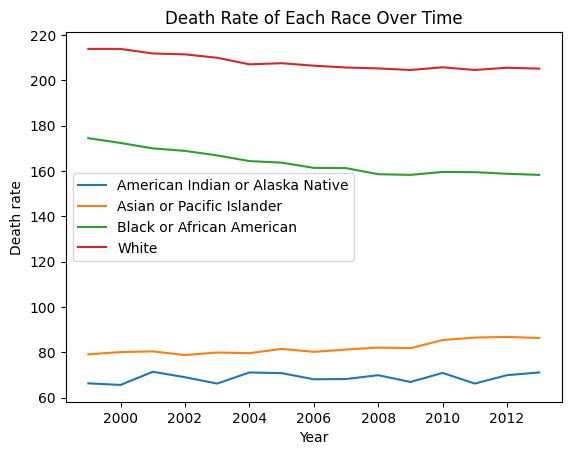

In [108]:
racial_dr_over_time.plot(xlabel="Year", ylabel="Death rate", title = 'Death Rate of Each Race Over Time')
plt.show()